In [ ]:
CURRENT_SAMPLE="S1W7D21_10_16_10"
# import helper functions including automated setup
from agilentpyvisa.reram_helpers_B1500 import *

# display images in the notebook %matplotlib notebook makes them interactive!
%matplotlib inline

import os
import os.path
today=datetime.today().strftime("%Y-%m-%d")
already_in = today in os.path.abspath(".")
if not already_in and not os.path.exists(today):
    os.mkdir(today)
if not already_in:
    os.chdir(today)
print("Working directory:")
print(os.path.abspath("."))

form_data={}
annealing_data={}


# Sample tests

Below is how I used the setup above when testing, together with the results

In [ ]:
form_sweep= plt.figure(figsize=[10,5])
f=form(3,100,10e-3, mrange=MeasureRanges_I.uA10_limited,gate=1.9)
f.to_csv("{}_form_3V.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
plt.autoscale()
form_data={}
form_data['FORM_GATE']=1.9
print(checkR(CURRENT_SAMPLE))
form_data['FORM_V']=find_set_V(f)
print(form_data['FORM_V'])

In [ ]:
print(checkR(CURRENT_SAMPLE))
r=reset_sweep(-1.5,100,5e-3, mrange=MeasureRanges_I.uA10_limited,gate=1.9,plot=True)
r.to_csv("{}_reset_{}.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'), CURRENT_SAMPLE))
print(checkR(CURRENT_SAMPLE))

In [ ]:
print(checkR(CURRENT_SAMPLE))
s=set_sweep(1.0,100,5e-3, mrange=MeasureRanges_I.uA10_limited,gate=1.9,plot=True)
s.to_csv("{}_set_{}.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'), CURRENT_SAMPLE))
print(checkR(CURRENT_SAMPLE))

In [ ]:
rh=get_hist(r)
plt.plot(rh['EV'],rh['R'])

In [ ]:
sh=get_hist(s)
plt.plot(sh['EV'],sh['R'])

In [ ]:
perc = np.ones(3)
iters= len(perc) 



frames,annealing_data=anneal(setV=1.0,resetV=-1.5,gateV=1.9,steps=100,times=3, plot=True,sleep_between=1)

In [ ]:
fhr

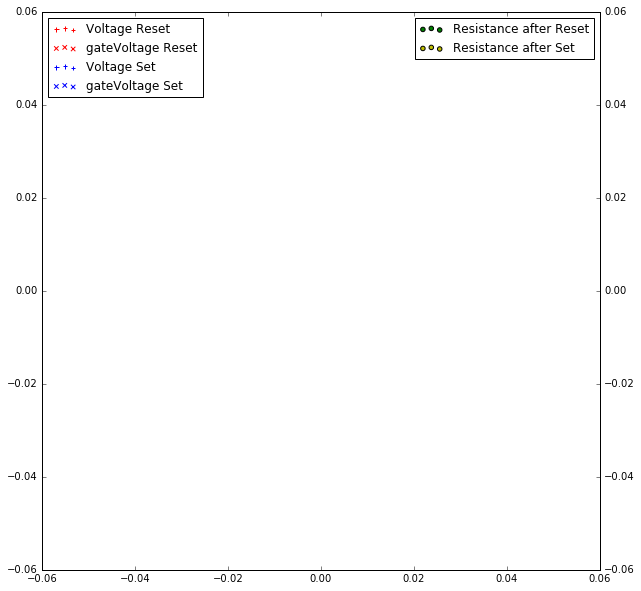

In [2]:
plot_pattern_results(fhr)

In [3]:
fhr

,0_RESET_HISTMAX,0_SET_HISTMAX,0_SET_V,1_RESET_HISTMAX,1_SET_HISTMAX,1_SET_V,2_RESET_HISTMAX,2_SET_HISTMAX,2_SET_V,Resistance,Type,Voltage,gateVoltage,slope,width
0,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
1,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
2,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
3,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
4,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
5,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
6,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
7,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
8,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
9,20920.41713,682.885806,0.8182,60643.376422,991.216848,0.6768,40529.813842,923.585164,0.596,None,None,None,None,None,None
